In [1]:
import sqlite3
import pandas
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
pandas.set_option('display.max_rows', 500)

In [3]:
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

## Part 1: Wrangling
### Problem 1

In [4]:
stats_query = "SELECT teamID, yearID, franchID, W, G, (W * 1.0) / (G * 1.0) * 100 as win_percentage FROM Teams"
team_stats = pandas.read_sql(stats_query, conn)
team_stats

,teamID,yearID,franchID,W,G,win_percentage
0,BS1,1871,BNA,20,31,64.516129
1,CH1,1871,CNA,19,28,67.857143
2,CL1,1871,CFC,10,29,34.482759
3,FW1,1871,KEK,7,19,36.842105
4,NY2,1871,NNA,16,33,48.484848
...,...,...,...,...,...,...
2770,PIT,2014,PIT,88,162,54.320988
2771,SDN,2014,SDP,77,162,47.530864
2772,SFN,2014,SFG,88,162,54.320988
2773,SLN,2014,STL,90,162,55.555556


In [5]:
salary_query = "SELECT yearID, teamID, salary  FROM Salaries"

team_salaries = pandas.read_sql(salary_query, conn)
team_salaries

,yearID,teamID,salary
0,1985,ATL,870000.0
1,1985,ATL,550000.0
2,1985,ATL,545000.0
3,1985,ATL,633333.0
4,1985,ATL,625000.0
...,...,...,...
24753,2014,WAS,3450000.0
24754,2014,WAS,3975000.0
24755,2014,WAS,20000000.0
24756,2014,WAS,7500000.0


Relation containing: total payroll, winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination), franchise ids, number of wins, number of games).

In [6]:
relation_query = '''WITH total_payroll as 
                    (SELECT teamID, 
                            yearID, 
                            sum(salary) as payroll 
                    FROM Salaries GROUP BY teamID, yearID)
                    SELECT Teams.teamID,
                        Teams.yearID,
                        Teams.lgID,
                        payroll,
                        franchID,
                        rank, 
                        W,
                        G, 
                        ((W * 1.0 / G * 1.0) * 100) as win_percentage
                    FROM total_payroll, Teams
                    WHERE total_payroll.yearID = Teams.yearID and
                    total_payroll.teamID = Teams.teamID'''
relation = pandas.read_sql(relation_query, conn)


In [7]:
relation.head()

,teamID,yearID,lgID,payroll,franchID,Rank,W,G,win_percentage
0,ATL,1985,NL,14807000.0,ATL,5,66,162,40.740741
1,BAL,1985,AL,11560712.0,BAL,4,83,161,51.552795
2,BOS,1985,AL,10897560.0,BOS,5,81,163,49.693252
3,CAL,1985,AL,14427894.0,ANA,2,90,162,55.555556
4,CHA,1985,AL,9846178.0,CHW,3,85,163,52.147239


#### Missing data: 
Teams starts from the year 1871, whereas Salaries starts from 1985.

In [8]:
relation['teamID'].unique()

array(['ATL', 'BAL', 'BOS', 'CAL', 'CHA', 'CHN', 'CIN', 'CLE', 'DET',
       'HOU', 'KCA', 'LAN', 'MIN', 'ML4', 'MON', 'NYA', 'NYN', 'OAK',
       'PHI', 'PIT', 'SDN', 'SEA', 'SFN', 'SLN', 'TEX', 'TOR', 'COL',
       'FLO', 'ANA', 'ARI', 'MIL', 'TBA', 'LAA', 'WAS', 'MIA'],
      dtype=object)

In [9]:
relation = relation[relation["yearID"] >= 1990]

## Part 2: Exploratory Data Analysis
### Problem 2
Distribution of payrolls across teams conditioned on time:

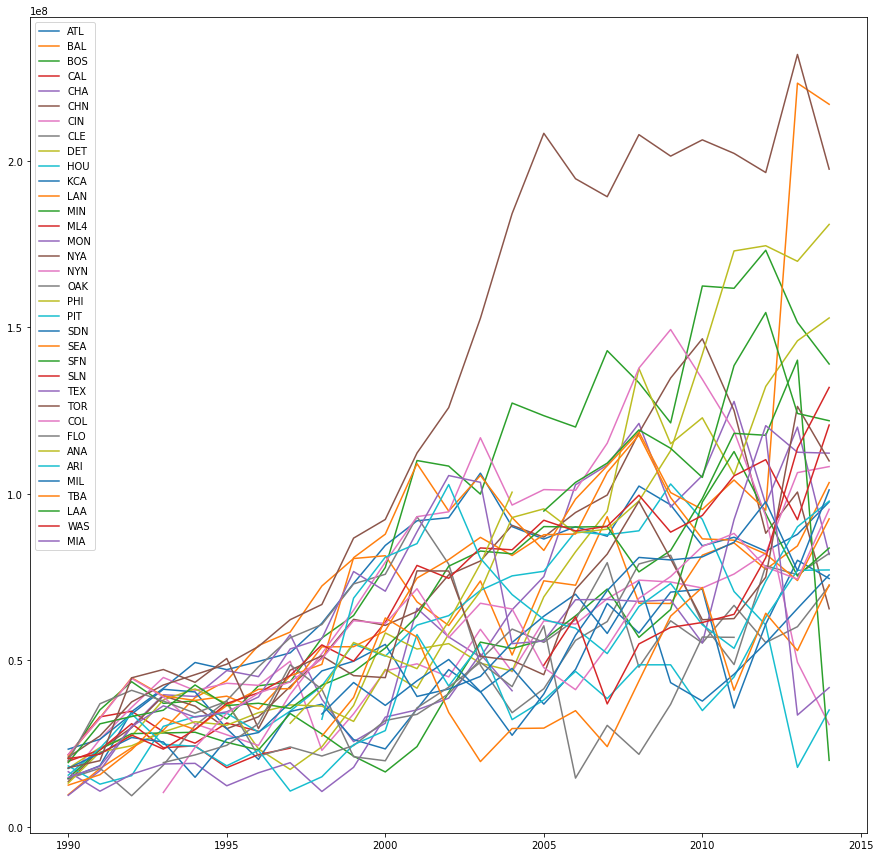

In [10]:
plt.figure(figsize=(15,15))
for team in relation["teamID"].unique():
    plt.plot(relation[relation.teamID == team]["yearID"],relation[relation.teamID == team]["payroll"], label = team)
    plt.legend()

Total payroll vs win percentage:

<AxesSubplot:xlabel='payroll', ylabel='win_percentage'>

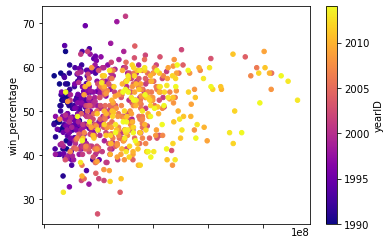

In [11]:
relation.plot.scatter(x = "payroll", y = "win_percentage", c="yearID", cmap="plasma")

### Question 1
What statements can you make about the distribution of payrolls conditioned on time based on these plots?

Based on the first plot, the central tendancy of the payroll got much higher as time progressed and so did the spread. The second plot shows that the win percentage stays about the same no matter the amount of money spent on the team. The second plot also confirms the statement made about the first plot; as time progressed, teams began to spend more money and only in the more recent years did teams did that begin to happen. The central tendancy of the second graph is towards the left, cheaper, side. 

### Problem 3

<AxesSubplot:xlabel='yearID', ylabel='win_percentage'>

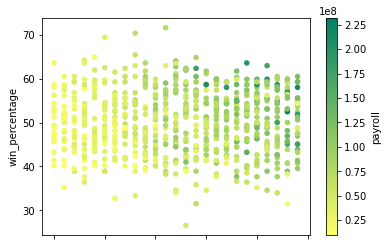

In [12]:
relation.plot.scatter(x = "yearID", y = "win_percentage", c="payroll", cmap="summer_r")

The above plot shows in another arrangment, with all the same elements as the last graph, that as time progresses (the points get darker), teams on average have a higher payroll but that does not increase their win percentage (the point remain relatively in the same range). Below is exactly the same plot as above, but using seaborn, showing the linear regression, which stays firmly at 50%. 

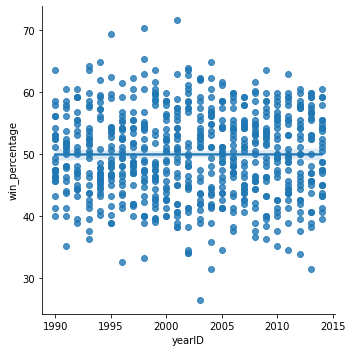

In [13]:
import seaborn as sns
sns.lmplot(x="yearID", y="win_percentage", data=relation)

### Problem 4

In [14]:
bins = pandas.cut(x = relation["yearID"], bins = 5, retbins=True)

year_lst = []
for i in range(5):
    year_lst.append((bins[1][i],bins[1][i+1]))


bin0 = relation[(relation["yearID"] >= year_lst[0][0]) & (relation["yearID"] < year_lst[0][1])]
bin1 = relation[(relation["yearID"] > year_lst[1][0]) & (relation["yearID"] < year_lst[1][1])]
bin2 = relation[(relation["yearID"] > year_lst[2][0]) & (relation["yearID"] < year_lst[2][1])]
bin3 = relation[(relation["yearID"] > year_lst[3][0]) & (relation["yearID"] < year_lst[3][1])]
bin4 = relation[(relation["yearID"] > year_lst[4][0]) & (relation["yearID"] <= year_lst[4][1])]

bin_lst = [bin0,bin1,bin2,bin3,bin4]

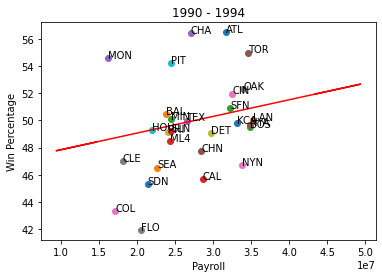

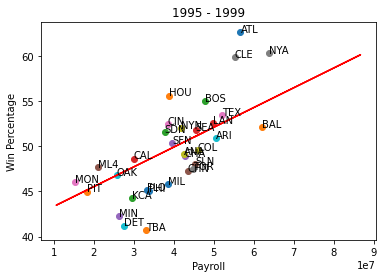

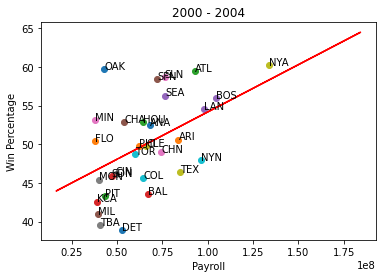

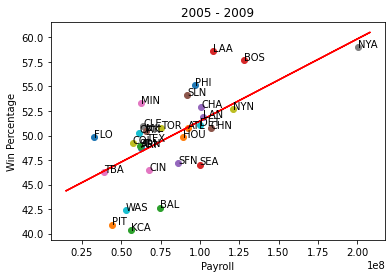

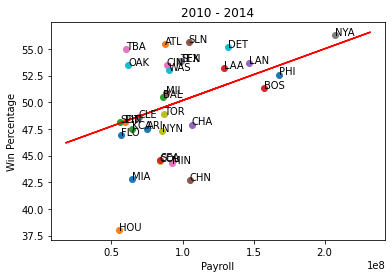

In [15]:
for bin_df in bin_lst:
       # plt.figure(figsize=(10,10))
       for team in bin_df["teamID"].unique():
              plt.scatter(bin_df[bin_df["teamID"] == team]["payroll"].mean(),bin_df[bin_df["teamID"] == team]["win_percentage"].mean() )
              plt.text(bin_df[bin_df["teamID"] == team]["payroll"].mean(),bin_df[bin_df["teamID"] == team]["win_percentage"].mean(),team)
       lin_regr = stats.linregress(bin_df["payroll"],y=bin_df["win_percentage"])
       plt.plot(bin_df["payroll"], lin_regr.intercept + lin_regr.slope*bin_df["payroll"],"r")
       plt.xlabel("Payroll")
       plt.ylabel("Win Percentage")
       title = "%d - %d" % (int(bin_df["yearID"].min()), int(bin_df["yearID"].max()))
       plt.title(title)

       plt.show()

### Question 2
What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods?

The Oakland A's were particularly efficient in thier spending efficiency. We can see that thier win percentage is far above the average for thier payroll amount. Especially for the years 2000-2014, the A's win percentage is still 7 points above the average for thier payroll.


## Part 3: Data Transformations
### Problem 5

In [16]:
std_payroll_array = []
for i,row in relation.iterrows():
    average_payroll = relation[relation['yearID'] == row["yearID"]]["payroll"].mean()
    std_payroll = relation[relation['yearID'] == row["yearID"]]["payroll"].std()
    standardized_payroll = (row["payroll"] - average_payroll) / std_payroll
    std_payroll_array.append(standardized_payroll)
relation["standardized payroll"] = std_payroll_array
relation.head()

,teamID,yearID,lgID,payroll,franchID,Rank,W,G,win_percentage,standardized payroll
130,ATL,1990,NL,14555501.0,ATL,6,65,162,40.123457,-0.667275
131,BAL,1990,AL,9680084.0,BAL,5,76,161,47.204969,-1.959861
132,BOS,1990,AL,20558333.0,BOS,1,88,162,54.320988,0.924213
133,CAL,1990,AL,21720000.0,ANA,4,80,162,49.382716,1.232198
134,CHA,1990,AL,9491500.0,CHW,2,94,162,58.024691,-2.009859


### Problem 6

In [17]:
bins = pandas.cut(x = relation["yearID"], bins = 5, retbins=True)

year_lst = []
for i in range(5):
    year_lst.append((bins[1][i],bins[1][i+1]))


bin0 = relation[(relation["yearID"] >= year_lst[0][0]) & (relation["yearID"] < year_lst[0][1])]
bin1 = relation[(relation["yearID"] > year_lst[1][0]) & (relation["yearID"] < year_lst[1][1])]
bin2 = relation[(relation["yearID"] > year_lst[2][0]) & (relation["yearID"] < year_lst[2][1])]
bin3 = relation[(relation["yearID"] > year_lst[3][0]) & (relation["yearID"] < year_lst[3][1])]
bin4 = relation[(relation["yearID"] > year_lst[4][0]) & (relation["yearID"] <= year_lst[4][1])]

bin_lst = [bin0,bin1,bin2,bin3,bin4]

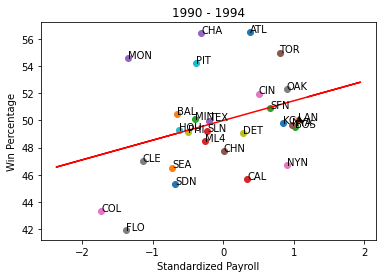

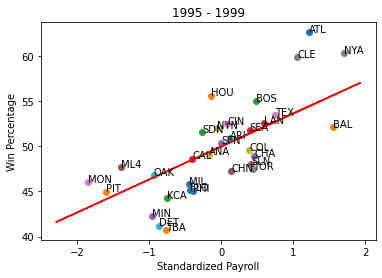

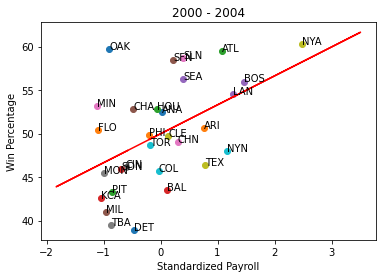

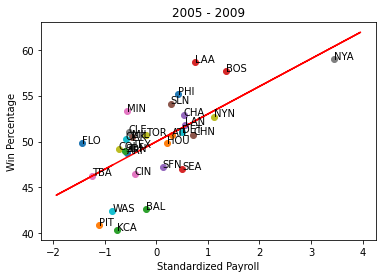

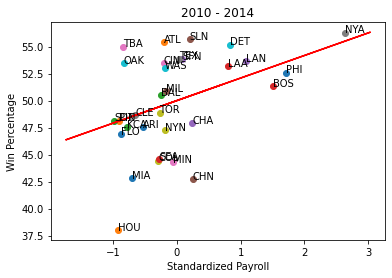

In [18]:
for bin_df in bin_lst:
       # plt.figure(figsize=(10,10))
       for team in bin_df["teamID"].unique():
              plt.scatter(bin_df[bin_df["teamID"] == team]["standardized payroll"].mean(),bin_df[bin_df["teamID"] == team]["win_percentage"].mean() )
              plt.text(bin_df[bin_df["teamID"] == team]["standardized payroll"].mean(),bin_df[bin_df["teamID"] == team]["win_percentage"].mean(),team)
       lin_regr = stats.linregress(bin_df["standardized payroll"],y=bin_df["win_percentage"])
       plt.plot(bin_df["standardized payroll"], lin_regr.intercept + lin_regr.slope*bin_df["standardized payroll"],"r")
       plt.xlabel("Standardized Payroll")
       plt.ylabel("Win Percentage")
       title = "%d - %d" % (int(bin_df["yearID"].min()), int(bin_df["yearID"].max()))
       plt.title(title)

       plt.show()

### Question 3
Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable. Specifically, what is easier to see, what is harder to see? Are any relationships more apparent?

### Problem 7

Text(0, 0.5, 'Win Percentage')

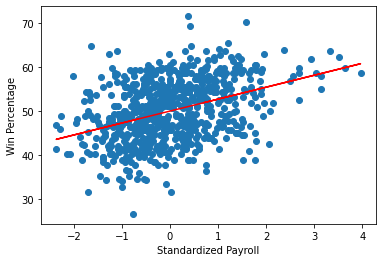

In [19]:
plt.scatter(x=relation["standardized payroll"],y=relation["win_percentage"])
lin_regr = stats.linregress(relation["standardized payroll"],y=relation["win_percentage"])
plt.plot(relation["standardized payroll"], lin_regr.intercept + lin_regr.slope*relation["standardized payroll"],"r")
plt.xlabel("Standardized Payroll")
plt.ylabel("Win Percentage")


### Problem 8

In [20]:
relation["efficiency"] = relation["win_percentage"] - (50 + (2.5*relation["standardized payroll"]))
print(relation["efficiency"].max(),relation["efficiency"].min())

20.65731993352356 -21.513506946415138


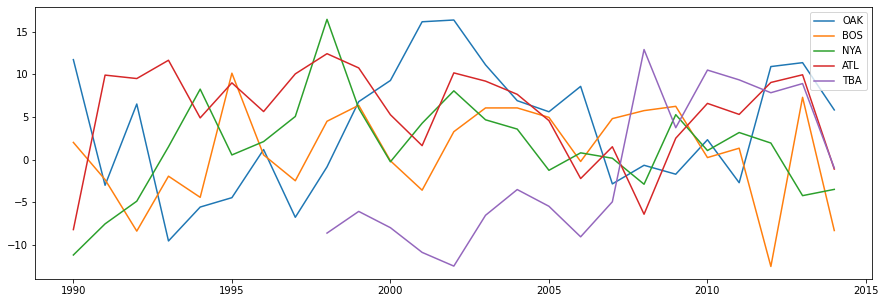

In [21]:

team_lst = ["OAK","BOS","NYA","ATL","TBA"]

plt.figure(figsize=(15,5)) #make figure wider for ease of viewing
for team in team_lst:
    plt.plot(relation[relation["teamID"]==team]["yearID"], relation[relation["teamID"]==team]["efficiency"],label=team)
plt.legend()

### Question 4

Oaklands efficiency was among the highest in the league during its moneyball period. Considering the highest efficiency in the league is around 20, it is impressive that the A's maintained a very high efficiency during its moneyball period.